## 3. Radiative Transfer Models
### By Susan Meerdink<sup>1</sup>

<sup>1</sup>The Machine Learning and Sensing Lab, Electrical and Computer Engineering, University of Florida, Gainesville, FL 32611
<url>https://faculty.eng.ufl.edu/machine-learning/</url>

**Background**  
Around 1987, Alexander F. H. Goetz first identified the need for developing an atmospheric correction technique using radiative transfer modeling (RTM), given the limitations of the empirical approaches for surface reflectance retrievals. RTMs use a theoretical modeling technique built on the physics of energy moving and interacting with the atmosphere and earth’s surface. These models try to account for absorption and scattering effects from atmospheric gases and aerosols. RTMs often produce better results than other methods because they capture the optics/physics of the atmosphere.
<img src="Picture02.png" alt="RS Basics" style="width: 600px;"/>

**Caveats**
* There are many attributes in an RTM that need to be approximated for accurate reflectance retrievals. RTMs require measurements or assumed values of atmospheric variables at the time of data acquisition that may be difficult to obtain, especially when dealing with historical datasets or the inaccessible zones. 
* Performance suffers for high water vapor, extreme viewing angles, surface/atmosphere coupling and heavy aerosol loads. 
* Consistent estimates of surface properties require accurate atmospheric correction across time, variable elevation, and atmospheric attenuation gradients. 
* RTMs are computationally expensive, require domain knowledge, and fine tuning.

**So when is it used?**  
* RTMs are used when there are limited number of targets in the scene to use for calibration using the empirical line method. This also includes collections where it would be infeasible to collect targets such as inhospital terrain, large spatial areas, or repeat collections. These limitations often apply to satellite imagery which is collected at higher temporal scales than drone or airborne and can cover large spatial areas that are not all accessible by humans.
* This method is also used if the data collection occurs near a meterological tower or airport which collects information about the atmosphere.
    * You can also release a radiosonde on a weather balloon during image collection. This data provides a detailed vertical profile of atmospheric gasses and temperature. However, this only provides one vertical profile for your entire image which may not be representative of your entire spatial area.

**Radiative Transfer Model Basics**  
Today there are many RTMs that all have slightly different approaches for retrieving reflectance, but they basically follow the radiative transfer model shown below (Gao and Goetz, 1990):

\begin{equation}
    r_s = \frac{\rho/ T_g - r_a}{T_d T_u + s(\rho/ T_g - r_a)}
\end{equation}

The symbol $\rho$ is the top of atmosphere reflectance, $T_g$ is the gaseous transmittance of the atmosphere, $r_a$ represents the total reflectance of the atmosphere along the optical path, $r_s$ is the surface reflectance, $T_u$ and $T_d$ represent upward and downward transmittances (both direct and diffuse). Here $s$ is the spherical albedo of the atmosphere producing an isotropic irradiance at the surface.

\begin{equation}
 \rho = \frac{\pi L}{F cos(\theta)}    
\end{equation}

where $L$ is the radiance measured by the instrument, $F$ is the solar downward irradiance at the top of the atmosphere, and $\theta$ is the solar zenith angle.The gaseous transmittance can be written as the product of transmittances of all relevant gasses:
 
\begin{equation}
    T_g = T_{H_{2}O} \; T_{O_{2}} \; T_{CO_{2}} \; T_{CH_{4}} \; T_{CO} \; T_{N_{2}O} 
\end{equation}

**Attributes of RTMs**  
There are many attributes in an RTM that need to be approximated for accurate reflectance retrievals. These can be generally grouped into 4 categories:

| Attributes | Constituents |
|---------------------|------|
| Atmospheric Profile | water vapor, oxygen, carbon dioxide, carbon monoxide, methane, nitrous oxide |
| Aerosol Profile | aerosols, dust, pollen, pollutants, smoke, etc. |
| Aerosol Optical Thickness | Atmospheric conditions |
| Geometry | solar angle, viewing angle, sensor altitude, target altitude |

We will go into more detail about each of these attributes below.

_Atmopsheric Profile_
* The atmospheric profile contains atmospheric gasses and water vapor. 
* Abundances of well-mixed gasses are effectively constant, so they are easier to model given a time and location on Earth. 
* However, water vapor concentrations are highly variable spatially, temporally, and vertically in the atmosphere. Often under or over estimation of water vapor concentrations yield the highest errors in retrieving reflectance. 
* Generally, the atmospheric profile attribute is approximated using predefined climates such as Mid-latitude Summer, Sub-Arctic Winter, or Tropical. These have present water vapor and surface air temperature values, which often do not capture specific conditions during an image’s collection. 
* Another way to provide the atmospheric profile is by collecting radiosonde data for that image time and date. This data provides a detailed vertical profile of atmospheric gasses and temperature. However, this is often only for one location and may not be applicable for an entire image scene especially if topography is highly variable.

_Aerosol Profile_
* The aerosol profile attribute is difficult to model and are often the poorest understood component of RTMs. This is mainly due to the highly variable concentrations and limited ability to measure the spatial and vertical distribution of aerosols. 
* Generally, the aerosol profile attribute is approximated using predefined models such as rural, urban, maritime, and tropospheric. These predefined models try to capture general aerosol conditions for an image, but if the image captures any events deviating from the normal (such as fires or dust storms), these models will not return accurate retrievals.

_Aerosol Optical Thickness_
* The aerosol optical thickness attribute is the sum of all absorption and scattering mechanisms as they vary with wavelength for one atmosphere. 
* This value changes depending on the quantity and values for all variables in Table 1. This variable can be complicated to calculate especially if the variables are unknown. 
* Often in RTMs, aerosol optical thickness is approximated using visibility expressed in kilometers.

_Geometry_
* While the other attributes are often approximated, this attribute is always known based on the time of image collection.


**RTM Approaches**  
There are many current implementations of RTM available (some are free while others cost money). They all have slightly different approaches for retrieving reflectance, but they basically follow the radiative transfer model shown above and have similar attributes. Often many have their own standalone software packages.

Some common RTMs available:
* ACORN (Kruse, 2004) 
* ATCOR (Richter and Schläpfer, 2002) 
* FLAASH (Perkins et al., 2012) 
* ATREM (Gao et al., 1993)
* others (Gao et al., 2000, 2007; Thompson et al., 2015)

In this module, we are going to use a RTM call Py6S which is a python interface to the 6S Radiative Transfer Model: https://py6s.readthedocs.io/en/latest/introduction.html. We are using it because it is fairly easy to use through python and has good documentation. You do not have a lot of control over the variables for each attribute and often can only use pre-defined profiles. 
    * Citation for Py6S v1.0: Wilson, R. T., 2013, Py6S: A Python interface to the 6S radiative transfer model, Computers and Geosciences, 51, p166-171.

In [1]:
# Imports and setup
import numpy as np
import rasterio
from Py6S import *

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
default_dpi = mpl.rcParamsDefault['figure.dpi']

Ancillary data associated with this file: ['wavelengths', 'rgb_index', 'rgb_image']
There are 273 bands for this 401 by 640 pixel image.


C:\Users\susanmeerdink\AppData\Local\Continuum\anaconda3\lib\site-packages\rasterio\__init__.py:223: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


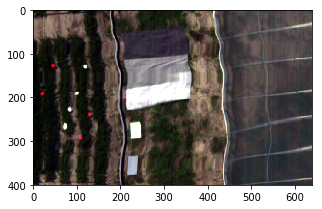

In [2]:
# Load the image
# Note: Image will have georeferencing error because it does gone through georeferencing yet which is normally done after reflectance.
imgFile = rasterio.open('img_radiance', 'r')

# Loading Metadata Data
data_anc = np.load('img_metadata.npz')
print('Ancillary data associated with this file: ' + str(data_anc.files))

# Set some of the variables from the ancillary data
wave = data_anc['wavelengths']
rgb_index = data_anc['rgb_index']
rgb_image = data_anc['rgb_image']

# Grab Some information about this image
pixHeight = rgb_image.shape[0]
pixWidth = rgb_image.shape[1]
numBands = len(wave)
print('There are ' + str(numBands) + ' bands for this ' + str(pixHeight) + ' by ' + str(pixWidth) + ' pixel image.')

# Display Red/Green/Blue or true color image
plt.figure(figsize=(5,5))
plt.imshow(rgb_image)

We are now going to set some parameters to run our first RTMs. For more information on options for these profiles see https://py6s.readthedocs.io/en/latest/params.html

First up the atmospheric profile:
* These options are standard in FLASSH and MODTRAN model atmopsheres. More information: https://www.harrisgeospatial.com/docs/FLAASH.html
<table><tr>
<td> <img src="Picture07.png" alt="Model Atmospheres 1" style="width: 500px;"/> </td>
<td> <img src="Picture08.png" alt="Model Atmospheres 2" style="width: 300px;"/> </td>
</tr></table>




In [3]:
# Create a SixS object
s = SixS()

# Set atmospheric profile
# Predefined Options: Tropical, MidlatitudeSummer, MidlatitudeWinter, SubArcticWinter, SubArcticSummer, USStandard1962
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.Tropical)

Next is the aerosol profile. As mentioned previously, RTMs follow the same basic calculations however they each have their own variations. One of those variations is in how the aerosol profile is calculated and inputted. The following is specific to Py6S and will probably vary compared to other RTMs. 

Pre-Defined Model Choices:
* _No Aerosols_: Does not include ANY aerosols in the RTM.
* _Continental_: Represents aerosols in areas not strongly affected by urban or industrial sources. The particle sizes are a blend of two distributions, one large and one small.
* _Maritime_: Represents the boundary layer over oceans, or continents under a prevailing wind from the ocean. It is composed of two components, one from sea spray and another from rural continental aerosol (that omits the largest particles).
* _Urban_: A mixture of 80% rural aerosol with 20% soot-like aerosols, appropriate for high-density urban/industrial areas.
* _Desert_:
* _BiomassBurning_:
* _Stratogspheric_: Applies to calm, clear (visibility greater than 40 km) conditions over land and consists of the small-particle component of the continental model.

User-Defined optional keywords that can be paired with model:
* _dust_: The proportion of dust-like aerosols
* _water_: The proportion of water-like aerosols
* _oceanic_: The proportion of oceanic aerosols
* _soot_: The proportion of soot-like aerosols


In [4]:
# Set the aerosol profile 
# Pre-Defined Options: NoAerosols, Continental, Maritime, Urban, Desert, BiomassBurning, Stratospheric
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)

Setting the Aerosol Optical Thickness (AOT) is next. In this implementation, the user can choose between setting the AOT measured at 550 nm or the visibility  measured in km.

In [5]:
# Set Aerosol Optical Thickness
s.aot550 = None
s.visibility = 20

The next attribute is geometry which for Py6S is separated into classes for geometry and altitude. 

There are some pre-defined geometries for some satellites, but we are using drone imagery so we are going to set our own user variables. I find this website by NOAA VERY useful for determining solar noon (for data collection), solar zenith angle, and solar azimuth angle. They also have a calculation excel sheet.
https://www.esrl.noaa.gov/gmd/grad/solcalc/

Geometry Attributes:
* solar_z – Solar zenith angle
* solar_a – Solar azimuth angle
* view_z – View zenith angle
* view_a – View azimuth angle
* day – The day the image was acquired in (1-31)
* month – The month the image was acquired in (0-12)

Altitude Attributes for custom sensor:
* altitude – The altitude of the sensor, in km.
* aot – (Optional, keyword argument) The AOT at 550nm at the sensor
* water – (Optional, keyword argument) The water vapour content (in g/cm^2) at the sensor
* ozone – (Optional, keyword argument) The ozone content (in cm-atm) at the sensor

In [6]:
# Set Geometry
s.geometry = Geometry.User()
s.geometry.solar_z = 31.81471
s.geometry.solar_a = 228.0553
s.geometry.day = 6
s.geometry.month = 9

# Set Altitudes
s.altitudes = Altitudes()
s.altitudes.set_sensor_custom_altitude(0.06)
s.altitudes.set_target_sea_level()

In [7]:
# # Grab Pixel
# window = ((100, 100 + 1), (75, 75 + 1))
# data = imgFile.read(window=window)  # Extract spectra from image
# pixel = np.squeeze(data)
# pixel_ref = np.zeros((len(pixel)))
# for p in np.arange(0, len(pixel)): #len(pixel)

#     # Turn on atmospheric correction mode 
#     if pixel[p] == 0:
#         pixel_ref[p] = 0
#     else:
#         # Set up atmospheric correction for pixel radiance
#         s.atmos_corr = AtmosCorr.AtmosCorrBRDFFromRadiance(pixel[p])

#         # Set Wavelengths
#         s.wavelength = Wavelength(wave[p]/1000)

#         # Run Model
#         s.run()

#         # Save Outputs
#         pixel_ref[p] = s.outputs.pixel_reflectance

# plt.figure()
# plt.scatter(wave, pixel_ref)
# print(pixel_ref)

In [27]:
# Run the model for the the Nano Hyperspec Cameras
wavelengths, results = SixSHelpers.Wavelengths.run_wavelengths(s, wave/1000, verbose=False)

Running for many wavelengths - this may take a long time


In [28]:
pix_total_rad = np.zeros((numBands))
pix_solar_spectrum = np.zeros((numBands))
pix_apparent_radiance = np.zeros((numBands))
for w in range(0,numBands):
    pix_total_rad[w] = results[w].pixel_radiance
    pix_solar_spectrum[w] = results[w].solar_spectrum
    pix_apparent_radiance[w] = results[w].apparent_radiance

Text(0.5, 1.0, 'apparent_radiance')

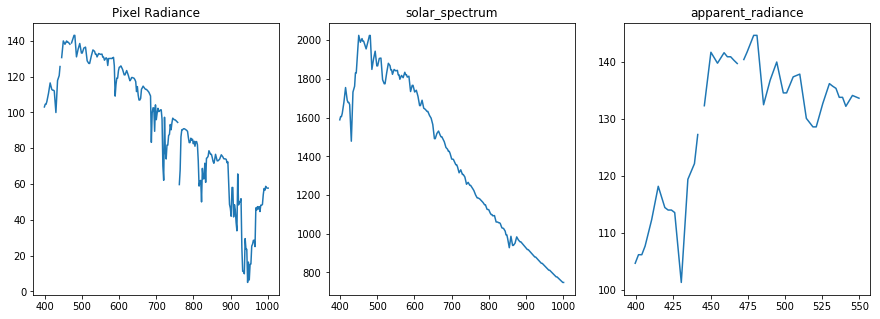

In [29]:
# Plot results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(wave, pix_total_rad)
plt.title('Pixel Radiance')
plt.subplot(1,3,2)
plt.plot(wave, pix_solar_spectrum)
plt.title('solar_spectrum')
plt.subplot(1,3,3)
plt.plot(wave, pix_apparent_radiance)
plt.title('apparent_radiance')

In [46]:
# Converting imagery to reflectance using RTM
imgRef = np.zeros((pixHeight, pixWidth, numBands))
for b in range(0,numBands): 
    imgRad = imgFile.read(indexes=b+1) # rasterio does count base 1 for bands
    imgRadConvert = imgRad/0.1 # converting to W/m^2 from mW/cm^2
    imgRef[:,:,b] = imgRad/(pix_total_rad[b]*0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Wavelength(nm)')

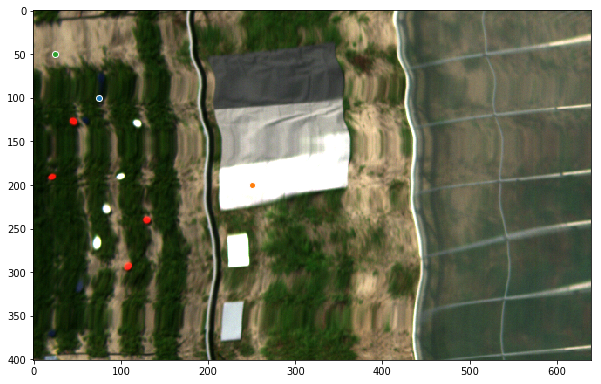

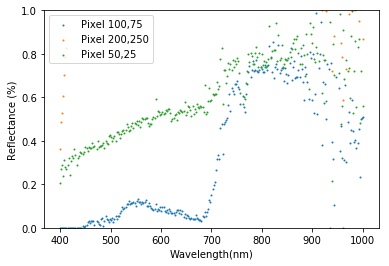

In [47]:
# Plot RGB of Reflectance Image and pull out some pixels
x = [100,200,50]
y = [75,250,25]
plt.figure(figsize=(10,10)) 
plt.imshow(imgRef[:,:, rgb_index]) # Applying Gamma Correction to brighten image
for i in range(0,len(x)):
    plt.scatter(y[i],x[i], edgecolors='w')
plt.show

# Loop through spectra to plot
plt.figure()
text = []
for i in range(0,len(x)):
    text.append('Pixel ' + str(x[i]) + ',' + str(y[i]))
    plt.scatter(wave,imgRef[x[i],y[i]], s=1)
plt.legend(text)
plt.ylim(0,1)
plt.ylabel('Reflectance (%)')
plt.xlabel('Wavelength(nm)')

In [13]:
results[0].values

{'version': '1.1',
 'month': 9,
 'day': 6,
 'solar_z': 31,
 'solar_a': 228,
 'view_z': 0,
 'view_a': 100,
 'scattering_angle': 148.19,
 'azimuthal_angle_difference': 128.06,
 'visibility': 20.0,
 'aot550': 0.2576,
 'ground_pressure': 1013.0,
 'ground_altitude': 0.0,
 'apparent_reflectance': 0.2436211,
 'apparent_radiance': 104.683,
 'total_gaseous_transmittance': 1.0,
 'wv_above_aerosol': 0.244,
 'wv_mixed_with_aerosol': 0.244,
 'wv_under_aerosol': 0.244,
 'percent_direct_solar_irradiance': 0.536,
 'percent_diffuse_solar_irradiance': 0.387,
 'percent_environmental_irradiance': 0.077,
 'atmospheric_intrinsic_reflectance': 0.001,
 'background_reflectance': 0.002,
 'pixel_reflectance': 0.24,
 'direct_solar_irradiance': 585.631,
 'diffuse_solar_irradiance': 423.421,
 'environmental_irradiance': 83.771,
 'atmospheric_intrinsic_radiance': 0.588,
 'background_radiance': 1.055,
 'pixel_radiance': 103.04,
 'solar_spectrum': 1588.603}

In [25]:
print(pix_apparent_radiance)

[104.683 106.184 106.184 107.693 110.006 112.334 115.289 118.194 116.336
 114.465 114.026 114.026 113.583 107.47  101.317 110.342 119.418 120.791
 122.17  127.279     nan 132.336 137.015 141.72  140.767 139.8   140.717
 141.638 140.927 140.927 140.306 139.743     nan 140.442 141.76  143.226
 144.686 144.686 138.598 132.509 134.673 136.816 138.412 140.006 137.297
 134.586 134.586 135.992 137.4   137.638 137.881 134.003 130.115 129.376
 128.621 128.621 130.679 132.734 134.485 136.216 135.763 135.382 133.807
 133.807 132.23  133.194 134.138 133.899 133.652     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan   